Program 3.4 from Keeling and Rohani 
----

*Author:* Theresa Stocks

*Date:* 2 Oct 2018

This Example is taken from Chapter 3, Program 3.4 in [Keeling and Rohani](http://www.modelinginfectiousdiseases.org) 

*NOTE*: This does not exactly reproduce the Figures from the python code 

"We consider the SEIR model with four age-classes and yearly aging, closely matching the implications of grouping individuals into school cohorts. The four age-classes modelled are 0-6, 6-10, 10-20 and 20+ years old.
Given that we are aiming for a mechanistic model, we have fixed the basic demography and only allow the epidemiological parameters to be altered (although by now you may have enough confidence in your programming to alter the terms that are fixed within the code).
Key to this model are two basic assumptions:

1) Only individuals in the adult class give birth, and only individuals in the adult class die.

2) Births and deaths are continuous, but aging only happens once per year.

The continuous time dynamics are given by:"

*here the equations of the model*

In [1]:
#Loading all necessary libraries 
library(deSolve)
library(tidyr)
library(reshape)
library(magrittr)
library(plyr)
library(ggplot2)
library(deSolve)
library(tidyr)
library(dplyr)


Attaching package: ‘reshape’

The following objects are masked from ‘package:tidyr’:

    expand, smiths


Attaching package: ‘magrittr’

The following object is masked from ‘package:tidyr’:

    extract


Attaching package: ‘plyr’

The following objects are masked from ‘package:reshape’:

    rename, round_any


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:reshape’:

    rename

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



### Parameters

In [2]:
m <- 4  #number of age classes
mu <- c(0,0,0,1/(55*365)) #death rate in each age group; it is assumed that only adults die
nu <- c(1/(55*365),0,0,0) #is the birth rate into the childhood class; it is assumed only adults give birth.
n <- c(6,4,10,55)/75 # fraction in each age class (assumption that life expectancy is 75 years)
S0 <- c(0.05,0.01,0.01,0.008) # inital value for number of susceptible
E0 <- c(0.0001,0.0001,0.0001,0.0001) # inital value for number of exposed
I0 <- c(0.0001,0.0001,0.0001,0.0001) # inital value for number of infectious
R0 <- c(0.0298, 0.04313333, 0.12313333, 0.72513333) # inital value for number of recovered
ND <- 365 # time to simulate
beta <- matrix(c(2.089, 2.089, 2.086, 2.037, 2.089, 9.336, 2.086, 2.037, 2.086, 2.086, 
                 2.086, 2.037, 2.037, 2.037, 2.037, 2.037), nrow=4, ncol=4) # matrix of transmission rates
gamma <- 1/5 # recovery rate
sigma <- 1/8 # rate at which individuals move from the exposed to the infectious classes
TS <- 1 # time step to simualte is days

# combining parameter and initial values
parms <- list(nu=nu, beta=beta, mu=mu, sigma=sigma, gamma=gamma)
INPUT <- c(S0, E0, I0, R0)

# constructing time vector
t_start <- 0 # starting time
t_end <- ND - 1 # ending time
t_inc <- TS #time increment
t_range <- seq(from= t_start, to=t_end+t_inc, by=t_inc) # vector with time steps

### Differential Equations

In [3]:
# differential equations
diff_eqs <- function(times, Y, parms){
  dY <- numeric(length(Y))
  with(parms,{
    # creates an empty matrix               
    for(i in 1:m){
      dY[i] <- nu[i]*n[4] -  beta[,i]%*%Y[2*m + seq(1:m)] * Y[i] - mu[i] * Y[i] # S_i
      dY[m+i] <-  beta[,i] %*% Y[2*m + seq(1:m)] *Y[i] - mu[i] * Y[m+i] - sigma * Y[m+i] #E_i
      dY[2*m+i] <- sigma * Y[m+i] - gamma * Y[2*m + i] - mu[i] * Y[2*m+i] #I_i
      dY[3*m+i] <- gamma * Y[2*m+i] - mu[i] * Y[3*m + i] #R_i
    }
    list(dY) 
  })
}

### Ageing

In [4]:
RES2=rep(0,17) #initalizing the result vector 
number_years <- 100 #set the number of years to simulate 

# initialize the loop
k=1
# yearly ageing
for(k in 1:number_years) {
  RES = lsoda(INPUT, t_range, diff_eqs, parms)
  #taking the last entry as the the new input that then is propagated accoring to the aging
  INPUT=RES[366,-1]
  INPUT[16]=INPUT[16]+INPUT[15]/10
  INPUT[15]=INPUT[15]+INPUT[14]/4-INPUT[15]/10
  INPUT[14]=INPUT[14]+INPUT[13]/6-INPUT[14]/4
  INPUT[13]=INPUT[13]-INPUT[13]/6

  INPUT[12]=INPUT[12]+INPUT[11]/10
  INPUT[11]=INPUT[11]+INPUT[10]/4-INPUT[11]/10
  INPUT[10]=INPUT[10]+INPUT[9]/6-INPUT[10]/4
  INPUT[9]=INPUT[9]-INPUT[9]/6
  
  INPUT[8]=INPUT[8]+INPUT[7]/10
  INPUT[7]=INPUT[7]+INPUT[6]/4-INPUT[7]/10
  INPUT[6]=INPUT[6]+INPUT[5]/6-INPUT[6]/4
  INPUT[5]=INPUT[5]-INPUT[5]/6

  INPUT[4]=INPUT[4]+INPUT[3]/10
  INPUT[3]=INPUT[3]+INPUT[2]/4-INPUT[3]/10
  INPUT[2]=INPUT[2]+INPUT[1]/6-INPUT[2]/4
  INPUT[1]=INPUT[1]-INPUT[1]/6
  RES2 <- rbind(RES2,RES)
  k=k+1
}

### Plotting

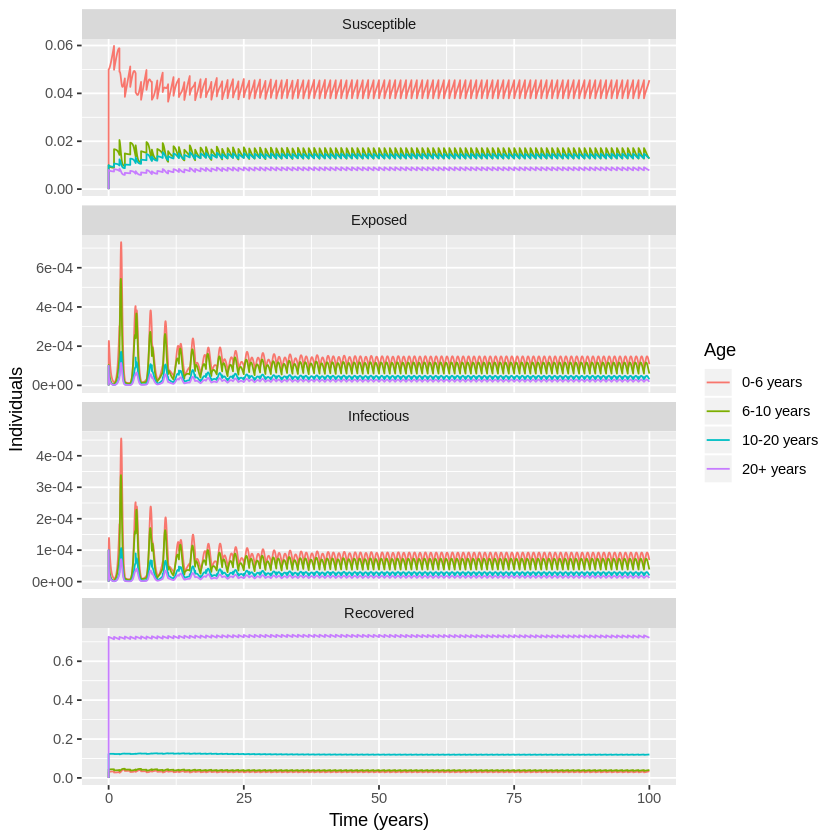

In [5]:
#rescaling time to years
time <- seq(from=0, to=100*(ND+1))/(ND+1)
#changing time to the rescaled time
RES2[ ,"time"] <- time

#labeling of the output from ODE solver
label <- c("S1", "S2", "S3", "S4","E1", "E2", "E3", "E4", "I1", "I2", "I3", "I4", "R1", "R2", "R3", "R4")
label1 <- substr(label, 1, 1)
Age <- substr(label, 2, 2)

df <- data.frame(time = RES2[, 1],
                 label1 = rep(label1, each =  nrow(RES2)),
                 Age = rep(Age, each =  nrow(RES2)),
                 value = c(RES2[, -1]))

#plotting  the data
df$label1 <- factor(df$label1, levels = c("S","E","I","R"))
df$Age <- factor(df$Age)
df %>% mutate(label1 = recode(label1, S = "Susceptible")) %>% 
       mutate(label1 = recode(label1, E = "Exposed")) %>% 
       mutate(label1 = recode(label1, I = "Infectious")) %>%
       mutate(label1 = recode(label1, R = "Recovered"))  %>%
       mutate(Age = recode(Age, "1" = "0-6 years ")) %>%
       mutate(Age = recode(Age, "2" = "6-10 years ")) %>%
       mutate(Age = recode(Age, "3" = "10-20 years ")) %>%       
       mutate(Age = recode(Age, "4" = "20+ years ")) %>%  
ggplot() +
   geom_line(aes(x = time, y = value, color = Age)) +
   facet_wrap( ~label1, ncol=1, scales =  "free_y")+ 
   xlab("Time (years)") + ylab(" Individuals")